In [1]:
!python -V
import torch, numpy, matplotlib, pandas, tqdm, importlib, sys, os, json
print("CUDA available:", torch.cuda.is_available())


Python 3.11.9
CUDA available: True


In [5]:
# Print current working directory
print("Current working directory:", os.getcwd())

Current working directory: d:\OneDrive - Princeton University\ResearchWork\Papers\03 - NN_for_FSI\analysis


[INFO] Preprocessing CSV files …
[INFO] Saved dataset → dataset.npz  (N=125)
[INFO] Launching interactive plot …  (close window to exit)


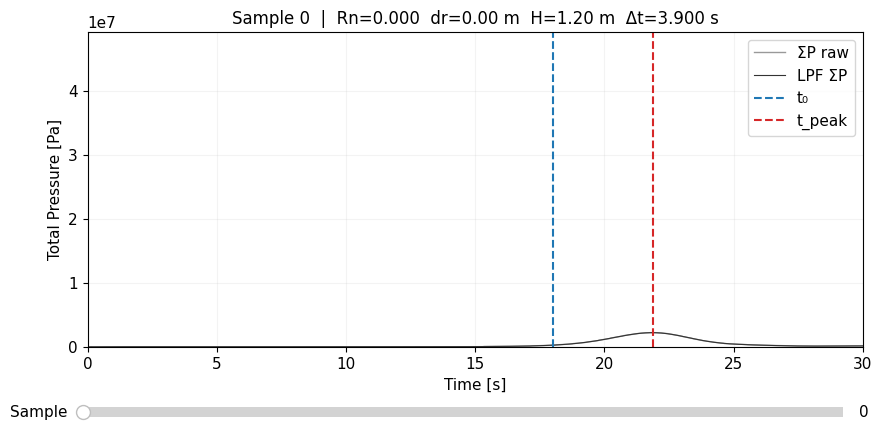

In [6]:
# regenerate dataset.npz (over-writes if exists)
%run src/preprocess_and_visualize.py

In [14]:
from src.dataloader import get_dataloaders
train_dl, test_dl, scaler = get_dataloaders(
    npz_path="data/dataset.npz",
    batch_size=8,
    seed=42,
    test_frac=0.20,
)
print("Train batches:", len(train_dl), "Test batches:", len(test_dl))


Train batches: 15 Test batches: 0


In [1]:
%run src/train.py --model fnn --epochs 1000 --batch 16 --device cuda:0
%run src/train.py --model cnn --epochs 1000 --batch 16 --device cuda:0
%run src/train.py --model deeponet --epochs 1000 --batch 8 --device cuda:0


FNN 1000/1000: 100%|██████████| 7/7 [00:00<00:00, 171.19it/s, loss=1e+6]


Best training loss = 7.6793e+05


CNN 1000/1000: 100%|██████████| 7/7 [00:00<00:00, 175.47it/s, loss=1.59e+9]


Best training loss = 9.8771e+08


DEEPONET 1000/1000: 100%|██████████| 15/15 [00:00<00:00, 139.03it/s, loss=1.78e+5]

Best training loss = 2.2131e+05


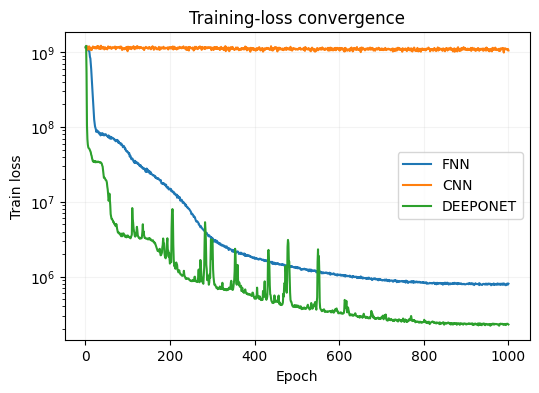

In [2]:
import pandas as pd, matplotlib.pyplot as plt, glob

plt.figure(figsize=(6,4))
for mdl in ["fnn", "cnn", "deeponet"]:
    hist = pd.read_csv(f"results/{mdl}/loss.csv")
    plt.plot(hist["epoch"], hist["train_loss"], label=mdl.upper())
plt.yscale("log"); plt.xlabel("Epoch"); plt.ylabel("Train loss"); plt.legend()
plt.title("Training-loss convergence"); plt.grid(alpha=0.15)


In [10]:
from pathlib import Path
from src.models.fnn import FNN
from src.models.cnn import CNN
from src.models.deeponet import DeepONet
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
metrics = {}

def load_model(mdl_name, cls):
    ckpt = torch.load(f"results/{mdl_name}/model.pt", map_location=device, weights_only=False)
    net  = cls().to(device)
    net.load_state_dict(ckpt["model_state"])
    net.eval()
    return net

nets = {
    "fnn": load_model("fnn", FNN),
    "cnn": load_model("cnn", CNN),
    "deeponet": load_model("deeponet", DeepONet),
}

with torch.no_grad():
    for name, net in nets.items():
        mse_p0 = mse_ppeak = mse_dt = 0.0
        n = 0
        for batch in test_dl:
            x = batch["x"].to(device)
            p0_gt = batch["p0"].to(device)
            ppk_gt = batch["ppk"].to(device)
            dt_gt  = batch["dt"].to(device)

            if name == "fnn":
                p0_pred, ppk_pred, dt_pred = net(x)
            elif name == "deeponet":
                grid = batch["grid"][0].to(device)
                maps, dt_pred = net(x, grid)
                p0_pred, ppk_pred = maps[:,0:1], maps[:,1:2]
            else:  # cnn
                maps, dt_pred = net(x)
                p0_pred, ppk_pred = maps[:,0:1], maps[:,1:2]

            mse_p0    += torch.mean((p0_pred  - p0_gt)**2).item() * x.size(0)
            mse_ppeak += torch.mean((ppk_pred - ppk_gt)**2).item() * x.size(0)
            mse_dt    += torch.mean((dt_pred  - dt_gt)**2).item() * x.size(0)
            n += x.size(0)

        if n > 0:
            metrics[name] = {
                "MSE_P0":    mse_p0 / n,
                "MSE_Ppeak": mse_ppeak / n,
                "MSE_dt":    mse_dt / n,
            }
        else:
            metrics[name] = {
                "MSE_P0":    float('nan'),
                "MSE_Ppeak": float('nan'),
                "MSE_dt":    float('nan'),
            }

import pandas as pd
display(pd.DataFrame(metrics).T)


,MSE_P0,MSE_Ppeak,MSE_dt
fnn,NaN,NaN,NaN
cnn,NaN,NaN,NaN
deeponet,NaN,NaN,NaN
